# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from scipy.stats import pearsonr, spearmanr, kruskal, mannwhitneyu

In [2]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    )) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name, 
    region_name,
    city_name
FROM afisha.purchases p
JOIN afisha.events e USING(event_id)
JOIN afisha.city c USING(city_id)
JOIN afisha.regions USING(region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [6]:
df = pd.read_sql_query(query, con=engine)
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


# В результате мы получили датафрейм с 290611 строками, 15 столбцами и индексами. 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

Типы данных указаны корректно, можно тип устройства перевести. Названия столбцов указаны корректно, данные соответствуют названию. 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [8]:
#Создадим датасет с данными о курсе тенге к рублю
currency_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [9]:
#Создадим переменную со средним курсом тенге к рублю за 2024 год
mean_currency = round(currency_df['curs'].mean(), 2)
print(mean_currency)

19.76


In [10]:
#Создадим в нашем датасете новый столбец, с пересчетом тенге в рубли
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub'
    else row['revenue'] * mean_currency,
    axis=1
)

#Столбец создан корректно. Рубли оставляет в изначальном виде, тенге же переводит по курсу. 
display(df.head(5))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [11]:
#Выгрузка была корректной. Пропуски есть только в days_since_prev
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [12]:
#Дублей нет, нормализовать нечего
for col in ['device_type_canonical', 'currency_code']:
    print(col, df[col].unique())


device_type_canonical ['mobile' 'desktop']
currency_code ['rub' 'kzt']


In [13]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,2260.128098,2.754311
std,18179.179204,1.170620
min,-90.760000,1.000000
25%,116.990000,2.000000
50%,359.400000,3.000000
75%,823.930000,4.000000
max,522174.993600,57.000000


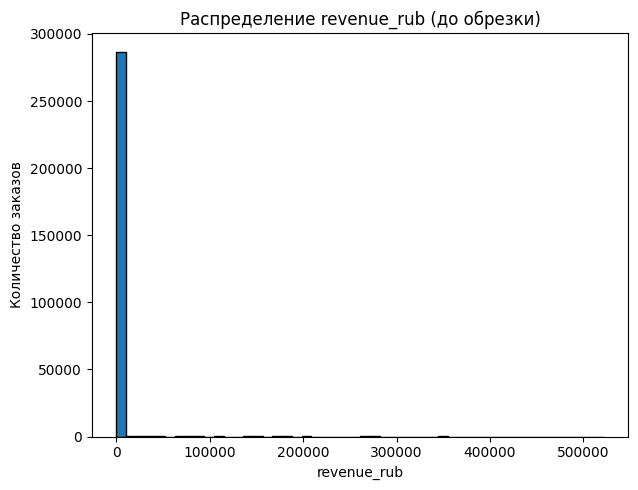

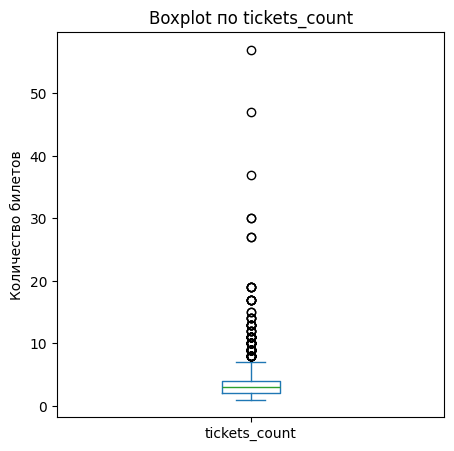

In [15]:
plt.figure(figsize=(12, 5))

#Распределение стоимости, учитывая все данные
plt.subplot(1, 2, 1)
plt.hist(df['revenue_rub'], bins=50, edgecolor='black')
plt.title('Распределение revenue_rub (до обрезки)')
plt.xlabel('revenue_rub')
plt.ylabel('Количество заказов')

plt.tight_layout()
plt.show()

#Ящик с усами по количеству билетов
plt.figure(figsize=(5, 5))
df['tickets_count'].plot(kind='box')
plt.title('Boxplot по tickets_count')
plt.ylabel('Количество билетов')
plt.show()

По графикам видно, что в данных достаточно много выбросов. Особенно в стоимости. На гистограмме с учетом все данных мы наблюдаем "скполение" данных в одном столбце. 

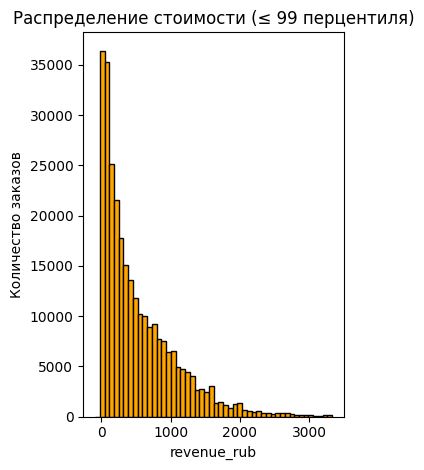

In [17]:
#Фильтруем значения по 99 перцентилю 
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

#Взглянем на новую гистограмму 
plt.subplot(1, 2, 2)
plt.hist(df['revenue_rub'], bins=50, color='orange', edgecolor='black')
plt.title('Распределение стоимости (≤ 99 перцентиля)')
plt.xlabel('revenue_rub')
plt.ylabel('Количество заказов')

plt.tight_layout()
plt.show()

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [18]:
#Для начала отсортируем наш датасет по времени совершения заказа
df = df.sort_values(by='order_ts', ascending=True)

display(df)
column_list = df.columns.tolist()
print(column_list)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
285281,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,1083.15
285282,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
118843,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,NaN,375861,ba89f19f-e73c-4d74-ab35-b9c023bb4de6,театр,Билеты в руки,Лесодальний край,Родниковец,2091.31
285279,fd4d47438ebb946,mobile,7565550,2024-06-01,2024-06-01 00:03:13,rub,812.36,3,NaN,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
264550,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0.0,211846,20165b73-7202-48df-a5e3-fd8cd1a70554,театр,Прачечная,Широковская область,Радужнополье,181.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156324,7eb4fc207ecc10f,mobile,7928369,2024-10-31,2024-10-31 23:58:55,rub,1954.78,5,0.0,420149,ecd3a795-c65a-48ac-904e-1d78e7c43ec6,концерты,Облачко,Каменевский регион,Глиногорск,1954.78
70015,3127060e4f02037,mobile,1307669,2024-10-31,2024-10-31 23:58:56,rub,578.72,3,0.0,589958,58051316-2668-4dfb-b442-6859638ea711,концерты,Мой билет,Североярская область,Озёрск,578.72
70011,3127060e4f02037,mobile,1307553,2024-10-31,2024-10-31 23:59:24,rub,578.72,3,0.0,589958,58051316-2668-4dfb-b442-6859638ea711,концерты,Мой билет,Североярская область,Озёрск,578.72
70012,3127060e4f02037,mobile,1307582,2024-10-31,2024-10-31 23:59:51,rub,385.81,2,0.0,589958,58051316-2668-4dfb-b442-6859638ea711,концерты,Мой билет,Североярская область,Озёрск,385.81


['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'days_since_prev', 'event_id', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'revenue_rub']


In [19]:
#Создадим новый дата фрейм, где будем хранить все полученные агрегированные признаки
df_users = pd.DataFrame() 

#Первым создадим столбец с уникальными user_id
df_users['user_id'] = df[['user_id']].drop_duplicates()

display(df_users)
#Получили список с 21401 строкой. Именно столько уникальных пользователей в оригинальном датасете

,user_id
285281,fd4d47438ebb946
118843,57ef0a1905ac488
264550,e73089d7d016cd8
37413,18e9aead0a393e7
27124,0e6fa925c5f346f
...,...
274000,f0dac51f739f59f
36876,176b51ad2feb561
186180,988e4859d820cb5
268244,e994c1637905fe5


In [20]:
# Первый заказ пользователя
first_orders = df.groupby('user_id').first().reset_index()

# Последний заказ пользователя
last_orders = df.groupby('user_id').last().reset_index()

In [21]:
#Группировка по остальным агрегированным признакам для пользователя  
agg_features = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    orders_count=('order_id', 'nunique'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()


In [22]:
agg_features = agg_features.merge(
    first_orders[['user_id', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']],
    on='user_id', how='left'
)

# Переименуем для удобства
agg_features.rename(columns={
    'device_type_canonical': 'first_device',
    'region_name': 'first_region',
    'service_name': 'first_service',
    'event_type_main': 'first_event_type'
}, inplace=True)

agg_features['is_two'] = (agg_features['orders_count'] >= 2).astype(int)
agg_features['is_five'] = (agg_features['orders_count'] >= 5).astype(int)

df_users = df_users.merge(agg_features, on='user_id', how='left')

df_users.head(15)

,user_id,first_order_dt,last_order_dt,orders_count,avg_revenue_rub,avg_tickets,avg_days_between,first_device,first_region,first_service,first_event_type,is_two,is_five
0,fd4d47438ebb946,2024-06-01,2024-10-31,1098,596.992750,2.698543,0.138560,mobile,Каменевский регион,Прачечная,театр,1,1
1,57ef0a1905ac488,2024-06-01,2024-09-26,4,797.937500,2.500000,39.000000,mobile,Лесодальний край,Билеты в руки,театр,1,0
2,e73089d7d016cd8,2024-06-01,2024-10-31,748,581.513663,2.748663,0.203481,mobile,Широковская область,Прачечная,театр,1,1
3,18e9aead0a393e7,2024-06-01,2024-10-31,4322,495.865421,2.790375,0.034020,mobile,Каменевский регион,Облачко,концерты,1,1
4,0e6fa925c5f346f,2024-06-01,2024-10-31,1479,563.748848,2.740365,0.100812,mobile,Речиновская область,Весь в билетах,концерты,1,1
5,868ed3e1cd9eb1b,2024-06-01,2024-10-30,37,898.766757,2.891892,4.194444,mobile,Белоярская область,Яблоко,концерты,1,1
6,028daec3ff80e05,2024-06-01,2024-10-31,48,372.813958,2.625000,3.234043,mobile,Каменевский регион,Лучшие билеты,спорт,1,1
7,0c01ef12c401336,2024-06-01,2024-10-31,629,518.282417,2.961844,0.238854,mobile,Глиногорская область,Облачко,концерты,1,1
8,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,10170,514.166273,2.873648,0.014849,mobile,Североярская область,Билеты в руки,концерты,1,1
9,55c565ecb7cea49,2024-06-01,2024-10-31,34,414.626176,3.000000,4.303030,mobile,Речицкая область,Билеты без проблем,концерты,1,1


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [23]:
print(f'Общее число пользователей в выборке: {df_users.shape[0]}')
print(f'Средня выручка с одного заказа: {round(df_users['avg_revenue_rub'].mean(), 2)}')
print(f'Доля пользователей с 2 и более заказами: {round(df_users['is_two'].mean(), 2)}')
print(f'Доля пользователей с 5 и более заказами: {round(df_users['is_five'].mean(), 2)}')
print(f'Общее число заказов: {df_users['orders_count'].sum()}')
print(f'Среднее число билетов в заказе: {round(df_users['avg_tickets'].mean(), 2)}')
print(f'Среднее количество дней между покупками: {round(df_users['avg_days_between'].mean(), 2)}')

Общее число пользователей в выборке: 21401
Средня выручка с одного заказа: 559.93
Доля пользователей с 2 и более заказами: 0.62
Доля пользователей с 5 и более заказами: 0.29
Общее число заказов: 284890
Среднее число билетов в заказе: 2.75
Среднее количество дней между покупками: 16.0


Число пользователей	21401. Этого достаточно для статистического анализа. Вполне рабочая выборка, по ней мы можем в дальнейшем строить стабильные агрегаты, сегментацию и ML-модели.
Число заказов	284890	В среднем 13 заказов на пользователя. Это довольно высокая активность, может указывать на постоянных клиентов, а не на случайных.
Средняя выручка с заказа 560 рублей. Выглядит адекватно.
Среднее число билетов в заказе тоже выглядит правдоподобно, часто люди покупают 2–3 билета за раз.
Средний интервал между заказами	16 дней. Правдоподобный результат.
Доля пользователей с 2 и более заказами 62%	Большинство пользователей вернулись хотя бы один раз — высокий уровень удержания.
Доля пользователей с 5 и более заказами	29%	Почти треть это лояльные клиенты. Хороший показатель.

Аномалии могут скрываться в распределениях числа заказов на пользователя, средней стоимости заказа.. Проверим распределение заказов:

In [24]:
df_users['orders_count'].describe(percentiles=[.5, .75, .9, .95, .99])

count    21401.000000
mean        13.311995
std        122.584897
min          1.000000
50%          2.000000
75%          5.000000
90%         15.000000
95%         32.000000
99%        155.000000
max      10170.000000
Name: orders_count, dtype: float64

Аномальные выбросы очевидны: половина пользователей 1–2 заказа, но у 1% пользователей количество заказов превышает 155, а максимальное значение и вовсе 10170 заказов. Этот длинный, правый хвост тянет среднее вверх (13.3 вместо реальной медианы 2). Такие пользователи в десятки и сотни раз активнее, чем типичные. 
Пользователи с тысячами заказов вероятно это корпоративные или агентские аккаунты, которые покупают массово сотнями или тысячами билетов. В таком случае нам следует отфильтровать результаты по 99% перцентилю. Конечно, можно было бы и по 95, тогда бы мы получили максимально типичного пользователя. Однако и лишились бы 5% данных. А это много, особенно учитывая причину. Поэтому сделаем отсев по 99% перцентилю. 

In [27]:
threshold = df_users['orders_count'].quantile(0.99)
df_users = df_users[df_users['orders_count'] <= threshold]

Проверим выбросы в средней стоимости заказа.

In [26]:
df_users['avg_revenue_rub'].describe(percentiles=[.5, .75, .9, .95, .99])

count    21187.000000
mean       560.292579
std        464.935161
min        -10.770000
50%        469.837500
75%        778.147042
90%       1145.867000
95%       1441.660000
99%       2220.644720
max       3332.030000
Name: avg_revenue_rub, dtype: float64

Выбросы не обнаружены, мы видим нормальное распределение. 

In [28]:
print(f'Общее число пользователей в выборке: {df_users.shape[0]}')
print(f'Средня выручка с одного заказа: {round(df_users['avg_revenue_rub'].mean(), 2)}')
print(f'Доля пользователей с 2 и более заказами: {round(df_users['is_two'].mean(), 2)}')
print(f'Доля пользователей с 5 и более заказами: {round(df_users['is_five'].mean(), 2)}')
print(f'Общее число заказов: {df_users['orders_count'].sum()}')
print(f'Среднее число билетов в заказе: {round(df_users['avg_tickets'].mean(), 2)}')
print(f'Среднее количество дней между покупками: {round(df_users['avg_days_between'].mean(), 2)}')
df_users.shape[0]

Общее число пользователей в выборке: 20978
Средня выручка с одного заказа: 561.04
Доля пользователей с 2 и более заказами: 0.61
Доля пользователей с 5 и более заказами: 0.28
Общее число заказов: 115279
Среднее число билетов в заказе: 2.75
Среднее количество дней между покупками: 16.49


20978

- Общее число пользователей в выборке: 21401 ====> 21187 --- Сократилось на 214. 
    
- Средня выручка с одного заказа: 559.93 ========> 560.29 -- Практически не изменилось

- Доля пользователей с 2 и более заказами: 0.62 => 0.61 ---- Практически не изменилось

- Доля пользователей с 5 и более заказами: 0.29 => 0.28 ---- Практически не изменилось

- Общее число заказов: 284890 ===================> 138548 -- Здесь мы видим заметные изменения. Более, чем в 2 раза. Именно столько заказов приходилось на "оптовых" покупателей 

- Среднее число билетов в заказе: 2.75 ==========> 2.75 ---- Не изменилось

- Среднее количество дней между покупками: 16.0 => 16.25 --- Практически не изменилось 

Как мы видим, фильтрация по 99 перцентиля данные практически никак не изменила, за исключением общего числа заказов

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [30]:
#Сегрегируем по кол-ву пользователей по типу первого мероприятия
seg_event = df_users.groupby('first_event_type').agg(
    users_count=('user_id', 'nunique')
).reset_index()
#Найдем их долю, от общего кол-во пользователей
seg_event['share'] = seg_event['users_count'] / df_users['user_id'].nunique()
seg_event = seg_event.sort_values(by='share', ascending=False)
display(seg_event)

,first_event_type,users_count,share
2,концерты,9068,0.432262
1,другое,5288,0.252074
5,театр,4258,0.202975
4,стендап,1110,0.052913
3,спорт,749,0.035704
0,выставки,410,0.019544
6,ёлки,95,0.004529


Распределение явно неравномерное. Основной входящий тип ивентов для посещения - это концерты (почти половина пользователей). Театр и категория «другое» дают ещё около 45 % аудитории. Остальные жанры дают менее 10 % в сумме. 
Итого, 3 категории концентрируют около 90% всех пользователей. Значит, вход на платформу сильно смещён в сторону массовых развлекательных мероприятий. Для полноты анализа не хватает уточняющих данных, о том, что входит в "другое"

Проделаем такую же работу для остальных признаков

In [31]:
seg_device = df_users.groupby('first_device').agg(
    users_count = ('user_id', 'nunique')
).reset_index()
seg_device['share'] = seg_device['users_count'] / df_users['user_id'].nunique()
seg_device = seg_device.sort_values(by='share', ascending=False)
display(seg_device)


,first_device,users_count,share
1,mobile,17420,0.830394
0,desktop,3558,0.169606


Абсолютное доминирование мобильных пользователей, более 4 из 5 совершают первый заказ с телефона. Можно уверенно сказать, что точка входа это мобильное устройство. Следует отдавать приоритет на развитие мобильного UX и маркетинга

In [32]:
seg_region = df_users.groupby('first_region').agg(
    users_count = ('user_id', 'nunique')
).reset_index()
seg_region['share'] = seg_region['users_count'] / df_users['user_id'].nunique()
seg_region = seg_region.sort_values(by='share', ascending=False)
display(seg_region)


,first_region,users_count,share
23,Каменевский регион,7102,0.338545
60,Североярская область,3768,0.179617
77,Широковская область,1237,0.058967
45,Озернинский край,683,0.032558
41,Малиновоярский округ,541,0.025789
...,...,...,...
17,Залесский край,2,0.000095
70,Тихогорская область,2,0.000095
5,Верхозёрский край,1,0.000048
66,Сосноводолинская область,1,0.000048


Распределение очень неравномерное. Два региона дают почти половину всех пользователей. Отсальные регионы имеют крайне показатели, часть буквально единицы пользователей. Это говорит нам о географической концентрации клиентской базы в Каменевском регионе и Североярской области.

In [33]:
seg_service = df_users.groupby('first_service').agg(
    users_count = ('user_id', 'nunique')
).reset_index()
seg_service['share'] = seg_service['users_count'] / df_users['user_id'].nunique()
seg_service = seg_service.sort_values(by='share', ascending=False)
display(seg_service)

,first_service,users_count,share
3,Билеты без проблем,4976,0.237201
18,Лови билет!,2829,0.134856
4,Билеты в руки,2543,0.121222
21,Мой билет,2495,0.118934
22,Облачко,2190,0.104395
7,Весь в билетах,1298,0.061874
19,Лучшие билеты,1180,0.056249
23,Прачечная,593,0.028268
16,Край билетов,455,0.021689
12,Дом культуры,356,0.016970


Здесь тоже наблюдается выраженная концентрация лидеров. Топ 5 операторов дают в сумме около 82% пользователей. Остальные же операторы делят между собой оставшиеся 18%, многие имеют совсем малую долю, менее 1 %. Это говорит о сильной зависимости от нескольких лидеров операторов.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [34]:
seg_event_repeat = (
    df_users.groupby('first_event_type', as_index=False)
    .agg(
        users_count=('user_id', 'nunique'),
        repeat_users=('is_two', 'sum')
    )
)
seg_event_repeat['repeat_share'] = seg_event_repeat['repeat_users'] / seg_event_repeat['users_count']
seg_event_repeat = seg_event_repeat.sort_values(by='repeat_share', ascending=False)

seg_device_repeat = (
    df_users.groupby('first_device', as_index=False)
    .agg(users_count=('user_id', 'nunique'),
         repeat_users=('is_two', 'sum'))
)
seg_device_repeat['repeat_share'] = seg_device_repeat['repeat_users'] / seg_device_repeat['users_count']
seg_device_repeat = seg_device_repeat.sort_values(by='repeat_share', ascending=False)

seg_region_repeat = (
    df_users.groupby('first_region', as_index=False)
    .agg(users_count=('user_id', 'nunique'),
         repeat_users=('is_two', 'sum'))
)
seg_region_repeat['repeat_share'] = seg_region_repeat['repeat_users'] / seg_region_repeat['users_count']
seg_region_repeat = seg_region_repeat.sort_values(by='repeat_share', ascending=False)

seg_service_repeat = (
    df_users.groupby('first_service', as_index=False)
    .agg(users_count=('user_id', 'nunique'),
         repeat_users=('is_two', 'sum'))
)
seg_service_repeat['repeat_share'] = seg_service_repeat['repeat_users'] / seg_service_repeat['users_count']
seg_service_repeat = seg_service_repeat.sort_values(by='repeat_share', ascending=False)

display(seg_event_repeat)
display(seg_device_repeat)
display(seg_region_repeat)
display(seg_service_repeat)


,first_event_type,users_count,repeat_users,repeat_share
0,выставки,410,260,0.634146
5,театр,4258,2696,0.633161
2,концерты,9068,5555,0.612594
4,стендап,1110,674,0.607207
1,другое,5288,3116,0.589259
3,спорт,749,421,0.562083
6,ёлки,95,52,0.547368


,first_device,users_count,repeat_users,repeat_share
0,desktop,3558,2247,0.631535
1,mobile,17420,10527,0.604305


,first_region,users_count,repeat_users,repeat_share
5,Верхозёрский край,1,1,1.000000
46,Озернопольская область,30,27,0.900000
51,Радужнопольский край,24,19,0.791667
36,Лесостепной край,61,44,0.721311
12,Горноземский регион,28,19,0.678571
...,...,...,...,...
6,Верхоречная область,65,20,0.307692
76,Шанырский регион,85,25,0.294118
48,Островогорский округ,5,1,0.200000
66,Сосноводолинская область,1,0,0.000000


,first_service,users_count,repeat_users,repeat_share
14,Зе Бест!,1,1,1.000000
30,Цвет и билет,2,2,1.000000
6,Быстрый кассир,58,49,0.844828
2,Билет по телефону,6,5,0.833333
25,Реестр,31,25,0.806452
8,Восьмёрка,89,62,0.696629
0,Crazy ticket!,43,29,0.674419
1,Show_ticket,165,108,0.654545
16,Край билетов,455,296,0.650549
12,Дом культуры,356,231,0.648876


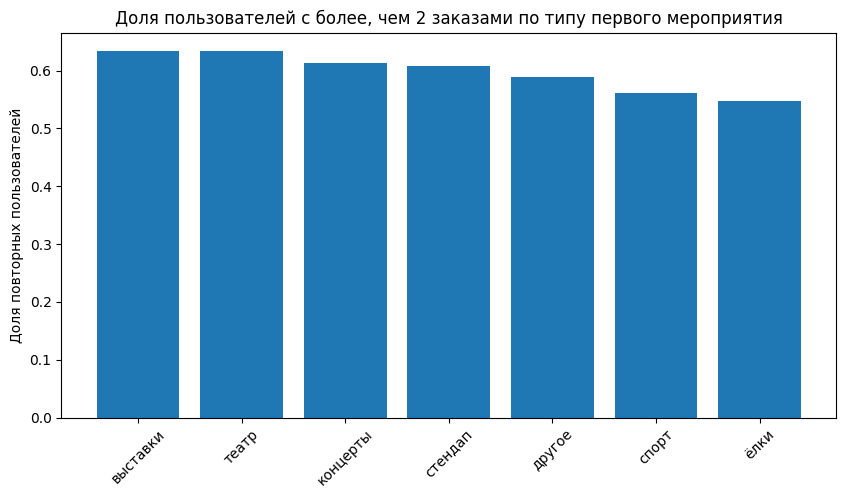

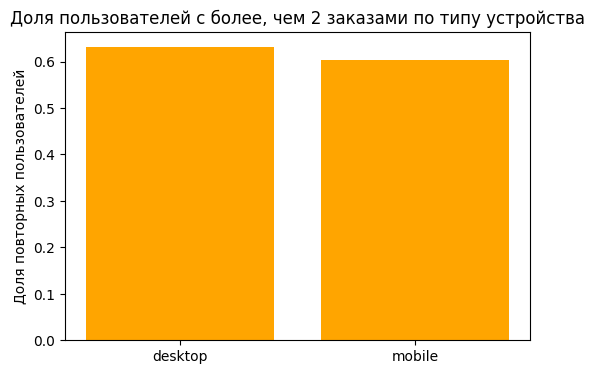

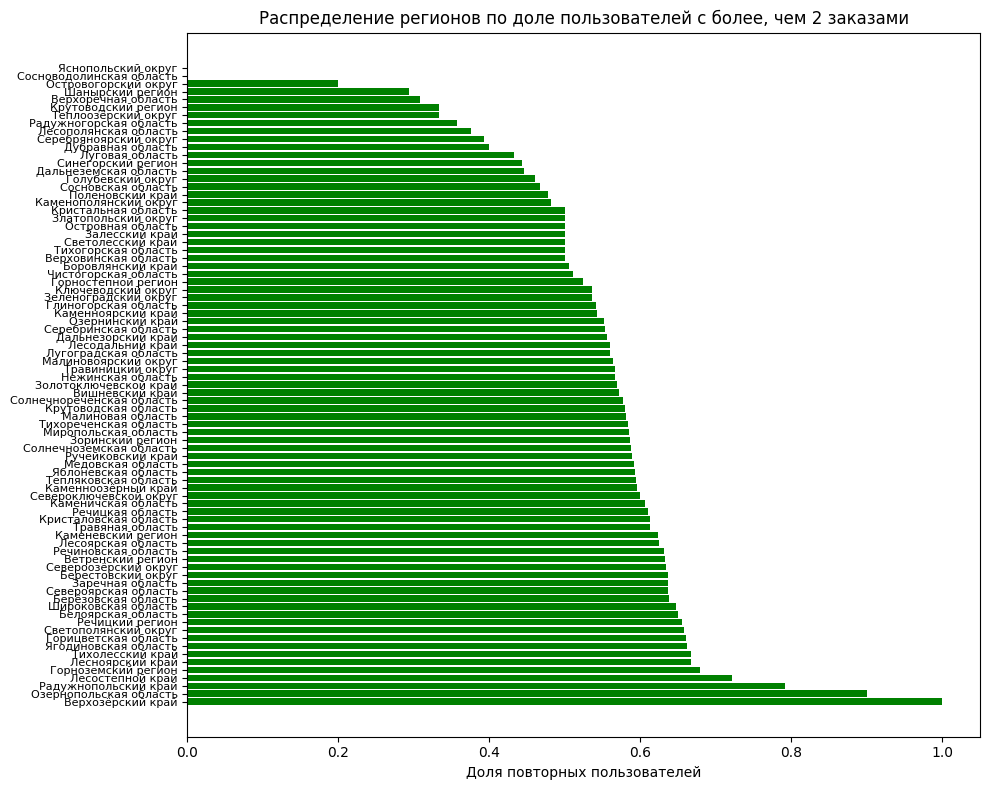

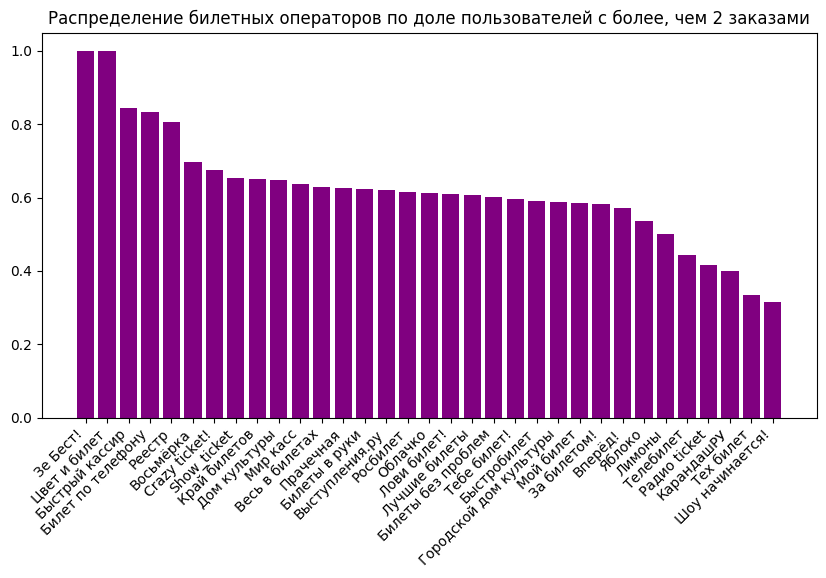

In [35]:
plt.figure(figsize=(10, 5))
plt.bar(seg_event_repeat['first_event_type'], seg_event_repeat['repeat_share'])
plt.title('Доля пользователей с более, чем 2 заказами по типу первого мероприятия')
plt.ylabel('Доля повторных пользователей')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(seg_device_repeat['first_device'], seg_device_repeat['repeat_share'], color='orange')
plt.title('Доля пользователей с более, чем 2 заказами по типу устройства')
plt.ylabel('Доля повторных пользователей')
plt.show()


plt.figure(figsize=(10, 8))
plt.barh(seg_region_repeat['first_region'], seg_region_repeat['repeat_share'], color='green')
plt.title('Распределение регионов по доле пользователей с более, чем 2 заказами')
plt.xlabel('Доля повторных пользователей')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(seg_service_repeat['first_service'], seg_service_repeat['repeat_share'], color='purple')
plt.title('Распределение билетных операторов по доле пользователей с более, чем 2 заказами')
plt.xticks(rotation=45, ha='right')
plt.show()

Тип первого мероприятия
Пользователи, впервые посетившие театр или выставку, чаще возвращаются на платформу. В этих сегментах доля пользователей, совершивших повторный заказ, составляет около 64 %, что немного выше среднего уровня в 62% по выборке. При этом театральная аудитория достаточно многочисленна, поэтому этот результат можно считать статистически устойчивым, в отличие от выставок, где выборка невелика. Концерты самый массовый сегмент, и показатель удержания здесь соответствует среднему значению. Аудитория стендапов и спортивных событий демонстрирует немного более низкую склонность к возвратам, а пользователи, пришедшие через сезонные мероприятия вроде ёлок, возвращаются реже всего. Таким образом, театральные события можно считать более “лояльной” точкой входа, способной формировать повторное использование сервиса.

Тип устройства
Поведение пользователей различается в зависимости от устройства, с которого был сделан первый заказ. Владельцы десктопов чаще совершают повторные заказы, 63.5% против 61% у мобильных пользователей. Хотя мобильная аудитория количественно доминирует, её удержание чуть ниже, что может указывать на отличия в пользовательском опыте или контексте использования. В целом, разница невелика, но стабильна, и десктоп можно считать более “удерживающим” каналом входа.

Регион
По регионам распределение менее устойчивое. Наиболее высокие доли повторных заказов наблюдаются в малых регионах, где количество пользователей исчисляется десятками, а иногда и единицами. Такие значения нельзя считать достоверными из-за малой выборки. Среди крупных регионов доли повторных заказов находятся в диапазоне 60–63%, что соответствует среднему уровню по всей базе. Существенных географических различий не выявлено, повторное поведение пользователей примерно одинаково независимо от региона.

Билетный оператор
В сегментах по билетным операторам также прослеживаются различия. Наиболее высокие доли возвратов демонстрируют клиенты операторов “Билеты в руки” и “Весь в билетах”. Это достаточно крупные сегменты, поэтому значения можно считать надёжными. У крупнейшего партнёра “Билеты без проблем” показатель удержания близок к среднему уровню, что говорит о стабильной, но не выдающейся повторной активности. Малые операторы с несколькими пользователями часто показывают доли 80-100%, однако эти результаты статистически незначимы. Таким образом, можно говорить о нескольких относительно успешных партнёрах, но без ярко выраженных лидеров по удержанию.

Общий вывод:
В целом пользователи возвращаются на Яндекс Афишу достаточно стабильно: около 62% совершают повторные заказы. Существенных различий между крупными сегментами нет, но наблюдаются умеренно успешные “точки входа”: театральные мероприятия, десктопные пользователи и клиенты отдельных операторов вроде “Билеты в руки”. Эти сегменты демонстрируют чуть более высокие показатели удержания и могут быть приоритетными при формировании маркетинговых стратегий и персонализированных предложений. В то же время большинство отклонений по сегментам незначительны, что говорит о том, что сервис удерживает пользователей примерно одинаково вне зависимости от канала входа, региона или партнёра.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [36]:
event_dummies = pd.get_dummies(seg_event_repeat['first_event_type'], prefix='event')

correlation_data = pd.concat([event_dummies, seg_event_repeat['repeat_share']], axis=1)

corr_matrix = correlation_data.corr()
print(corr_matrix['repeat_share'].sort_values(ascending=False))

repeat_share      1.000000
event_выставки    0.474827
event_театр       0.461894
event_концерты    0.191910
event_стендап     0.121202
event_другое     -0.114405
event_спорт      -0.471138
event_ёлки       -0.664290
Name: repeat_share, dtype: float64


Гипотеза 1. Тип мероприятия влияет на вероятность возврата: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
Что показывают данные: Концерты: 61.7% пользователей совершают повторный заказ, корреляция между первым типом ивента и повторным обращением 0.19.
Спорт: 56.7% пользователей совершают повторный заказ. Корреляция -0.43
То есть у спортивных событий доля повторных заказов ниже, чем у концертов примерно на 5 процентных пунктов. И ощутимая разница в коэфеициенте корреляции. Также необходимо учитывать, концертная аудитория очень крупная, свыше 9000 пользователей, что делает показатель устойчивым. В то же аудитория спортивных мероприятий существуенно нижек, но всё же достаточно значимая, более 700 пользователей, чтобы считать разницу надёжной.

Вывод: гипотеза не подтверждается.
Тип мероприятия действительно влияет на вероятность возврата, но в противоположную сторону: пользователи, впервые купившие билеты на спортивные мероприятия, возвращаются реже, чем те, кто впервые покупал билеты на концерты.


In [37]:
pearson_corr, pearson_p = pearsonr(seg_region_repeat['users_count'], seg_region_repeat['repeat_share'])
spearman_corr, spearman_p = spearmanr(seg_region_repeat['users_count'], seg_region_repeat['repeat_share'])

print('Корреляция Пирсона: ')
print(f'Коэффициент: {pearson_corr:.3f}, p-value: {pearson_p:.4f}')
print('Корреляция Спирмена: ')
print(f'Коэффициент: {spearman_corr:.3f}, p-value: {spearman_p:.4f}')

Корреляция Пирсона: 
Коэффициент: 0.127, p-value: 0.2592
Корреляция Спирмена: 
Коэффициент: 0.317, p-value: 0.0039


Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Корреляционный анализ показывает, что между количеством пользователей и долей повторных заказов нет линейной зависимости. Однако по Спирмену видно, что в целом при росте числа пользователей доля вернувшихся немного увеличивается.

Крупнейшие регионы: Каменевский регион, Североярская область, Широковская область. Они формируют основную долю пользователей - более половины всей базы. При этом их доли повторных пользователей находятся в диапазоне около 60–63%, то есть на уровне среднего по всей выборке - примерно 62%. Высокие значения (70–90%) наблюдаются только в маленьких регионах, где по несколько десятков или даже единиц пользователей, т.е. это статистически нестабильные значения.

Вывод: гипотеза не подтверждается.
В крупных регионах, где больше всего пользователей, доля повторных заказов не выше, чем в остальных, она примерно на среднем уровне. Таким образом, размер пользовательской базы региона не связан с удержанием: высокая активность по количеству пользователей не означает более лояльную аудиторию.


Общий вывод:

1) Тип мероприятия действительно влияет на возврат, но не в пользу спортивных событий — больше возвращаются зрители театров и концертов.

2) Размер региона по числу пользователей не влияет на вероятность повторного заказа.

Это значит, что удержание в сервисе определяется не масштабом региона, а, скорее всего, качеством первого опыта, типом мероприятия, удобством покупки и вовлечённостью пользователя.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


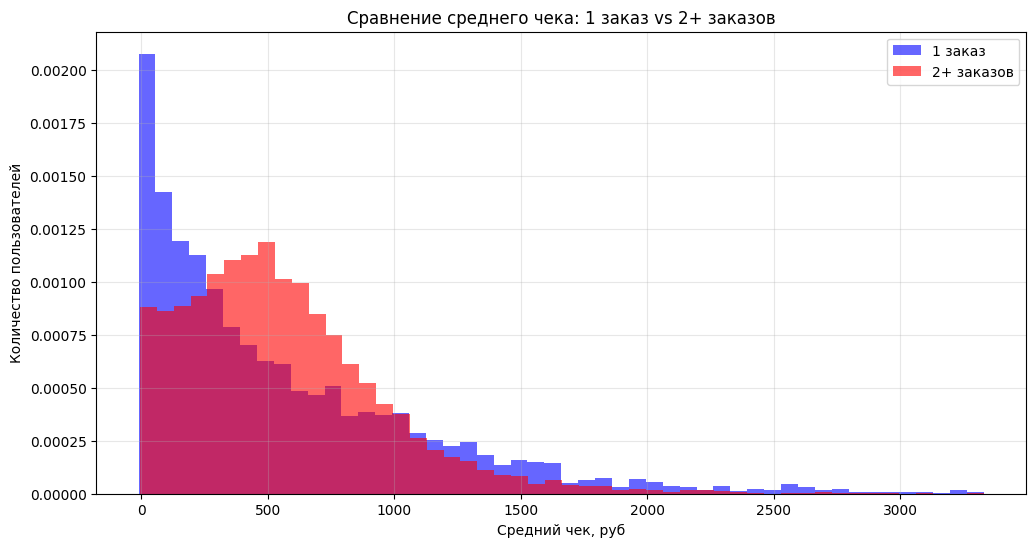

In [38]:
one_order = df_users[df_users['orders_count'] == 1]['avg_revenue_rub']
multiple_orders = df_users[df_users['orders_count'] >= 2]['avg_revenue_rub']

plt.figure(figsize=(12, 6))

plt.hist(one_order, bins=50, alpha=0.6, label='1 заказ', color='blue', density=True)
plt.hist(multiple_orders, bins=50, alpha=0.6, label='2+ заказов', color='red', density=True)

plt.title('Сравнение среднего чека: 1 заказ vs 2+ заказов')
plt.xlabel('Средний чек, руб')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Пользователи с 1 заказом:
- Основная концентрация в диапазоне до 0 до 400 руб.
- Наибольший пик около 100–200 руб.
- После 400 руб количество таких пользователей быстро снижается, но хвост распределения длинный, есть и те, у кого средний чек доходит до 3000 руб, однако их очень мало.

Пользователи с 2+ заказами:
- Основная концентрация в диапазоне от 300 до 700 руб.
- Пик смещён правее по сравнению с пользователями с одним заказом.
- Также наблюдается постепенное уменьшение плотности к 1500 руб. и выше.


Пользователи с одним заказом имеют, в среднем, меньший средний чек, чем те, кто совершал несколько заказов. У повторных клиентов кривая смещена вправо, то есть они склонны тратить больше за один заказ. Однако распределения частично пересекаются — среди клиентов с одним заказом есть и те, кто тратит много, но таких заметно меньше.

Вывод:
Основная масса пользователей с 1 заказом - это дешёвые заказы до 300–400 руб. Основная масса пользователей с 2 и более заказами - это заказы среднего уровня 300–700 руб.
Различие между группами выражено - более лояльные пользователи делают заказы с более высоким средним чеком.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


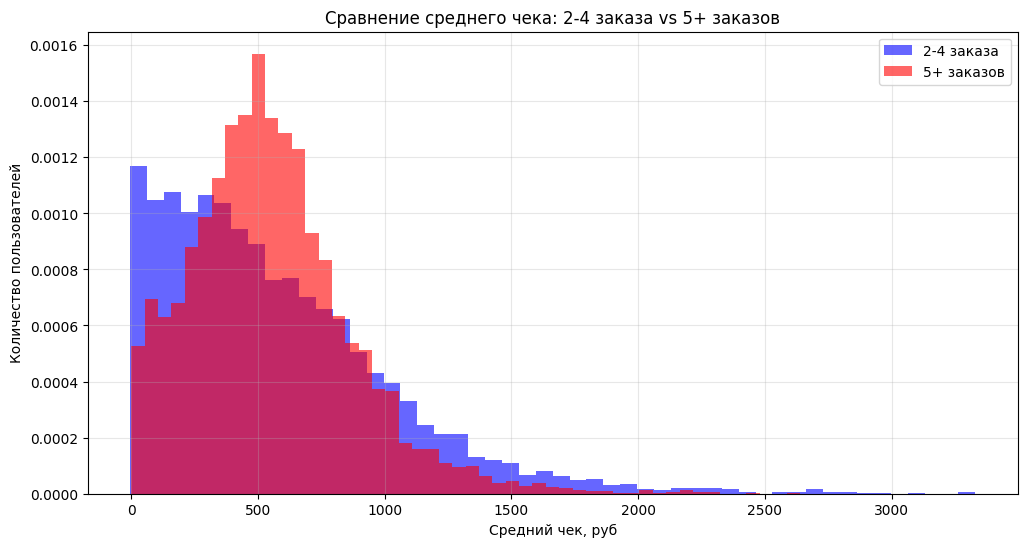

In [39]:
two_four_order = df_users[(df_users['orders_count'] >= 2) & (df_users['orders_count'] < 5)]['avg_revenue_rub']
five_orders = df_users[df_users['orders_count'] >= 5]['avg_revenue_rub']

plt.figure(figsize=(12, 6))

plt.hist(two_four_order, bins=50, alpha=0.6, label='2-4 заказа', color='blue', density=True)
plt.hist(five_orders, bins=50, alpha=0.6, label='5+ заказов', color='red', density=True)

plt.title('Сравнение среднего чека: 2-4 заказа vs 5+ заказов')
plt.xlabel('Средний чек, руб')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Группа с 2-4 заказами:
- распределение более растянуто,
- основной пик находится в диапазоне 200–400 р,
- встречаются пользователи с как низким, так и довольно высоким средним чеком.

Группа с 5+ заказами:
- распределение смещено правее,
- основной пик в диапазоне 400–600 рублей,
- пользователи с большим числом заказов чаще имеют более высокий средний чек,
- при этом распределение у них более сфокусированное, с меньшеим разбросом.

Общий выовд:
Средний чек у пользователей, совершивших 5 и более заказов, значимо выше, чем у тех, кто сделал 2–4 заказа. Различие проявляется не только в пиках распределений, но и в общей форме: лояльные пользователи тратят стабильно больше, а их средние чеки менее вариативны. Это может говорить о формировании устойчивого покупательского поведения. Клиенты, совершающие много заказов, реже совершают очень дешёвые покупки и чаще делают покупки в среднем и высоком сегменте чеков.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [40]:
#Создаём сегменты по среднему количеству билетов
def ticket_segment(x):
    if 1 <= x < 2:
        return '1–2 билета'
    elif 2 <= x < 3:
        return '2–3 билета'
    elif 3 <= x < 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

df_users['ticket_segment'] = df_users['avg_tickets'].apply(ticket_segment) #Создаем столбец с аггрегированием по сегментам

# Считаем статистику
segment_stats = (
    df_users.groupby('ticket_segment')
    .agg(
        users_count=('user_id', 'count'),
        repeat_share=('is_two', 'mean'),   # доля повторных покупателей, 2+
        loyal_share=('is_five', 'mean')    # доля частых покупателей, 5+
    )
    .reset_index()
)

segment_stats['repeat_share'] = (segment_stats['repeat_share'] * 100).round(2)
segment_stats['loyal_share'] = (segment_stats['loyal_share'] * 100).round(2)

segment_stats

,ticket_segment,users_count,repeat_share,loyal_share
0,1–2 билета,2395,51.02,14.49
1,2–3 билета,9053,72.77,39.98
2,3–5 билетов,8859,54.58,20.76
3,5+ билетов,671,19.23,2.24


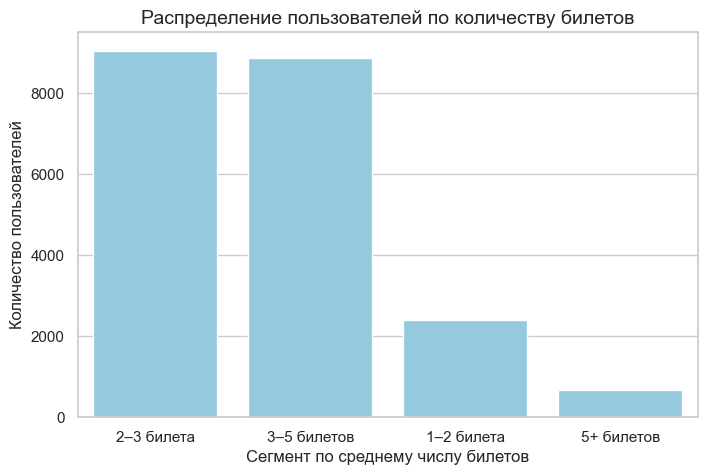

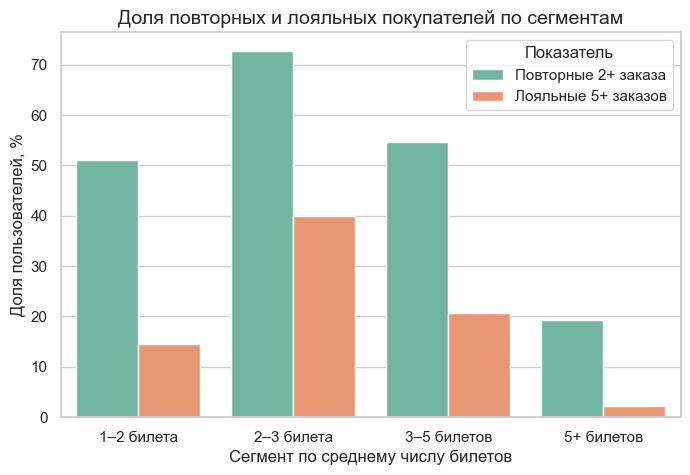

In [41]:
sns.set(style="whitegrid", palette="Set2")

#Распределение пользователей по сегментам
plt.figure(figsize=(8, 5))
sns.barplot(
    data=segment_stats.sort_values('users_count', ascending=False),
    x='ticket_segment', y='users_count', color='skyblue'
)
plt.title('Распределение пользователей по количеству билетов', fontsize=14)
plt.xlabel('Сегмент по среднему числу билетов')
plt.ylabel('Количество пользователей')
plt.show()

#Копируем датафрейм для наглядности
plot_df = segment_stats.melt(
    id_vars='ticket_segment',
    value_vars=['repeat_share', 'loyal_share'],
    var_name='metric',
    value_name='share'
)

# Заменяем значения в столбце metric на человеко-читаемые
plot_df['metric'] = plot_df['metric'].map({
    'repeat_share': 'Повторные 2+ заказа',
    'loyal_share': 'Лояльные 5+ заказов'
})

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='ticket_segment', y='share', hue='metric')

plt.title('Доля повторных и лояльных покупателей по сегментам', fontsize=14)
plt.xlabel('Сегмент по среднему числу билетов')
plt.ylabel('Доля пользователей, %')
plt.legend(title='Показатель')
plt.show()

Больше всего пользователей в сегментах 2–3 и 3–5 билетов — вместе они составляют около 85 % аудитории.
Наиболее активный и лояльный сегмент - это группа со средним показателем в 2–3 билета: среди этой группы 73% людей покупали билеты повторно и 41% возвращались более пяти раз.
У сегмента в среднем 5+ билетов крайне низкий процент возврата за повторным заказом, вероятно, это разовые групповые покупки.
Сегмент 1–2 билета характеризуется умеренной вовлечённостью: 51% повторных заказов, 14% лояльных.

Вывод:
Самый устойчивый и перспективный для удержания клиентов сегмент - пользователи, покупающие 2–3 билета за заказ. Именно они обеспечивают наибольшую долю повторных и лояльных покупок при большом объёме аудитории.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [42]:
df_users['first_order_dow'] = df_users['first_order_dt'].dt.day_name()
dow_stats = (
    df_users.groupby('first_order_dow')
    .agg(
        users_count=('user_id', 'count'),
        repeat_share=('is_two', 'mean')
    )
    .reset_index()
)

# Переводим долю в проценты
dow_stats['repeat_share'] = (dow_stats['repeat_share'] * 100).round(2)

# Чтобы дни шли по порядку, добавим категориальный тип
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats['first_order_dow'] = pd.Categorical(dow_stats['first_order_dow'], categories=dow_order, ordered=True)
dow_stats = dow_stats.sort_values('first_order_dow')
dow_stats

,first_order_dow,users_count,repeat_share
1,Monday,2776,62.46
5,Tuesday,2985,61.14
6,Wednesday,2946,61.64
4,Thursday,3073,59.84
0,Friday,3203,59.66
2,Saturday,3252,61.99
3,Sunday,2743,59.53


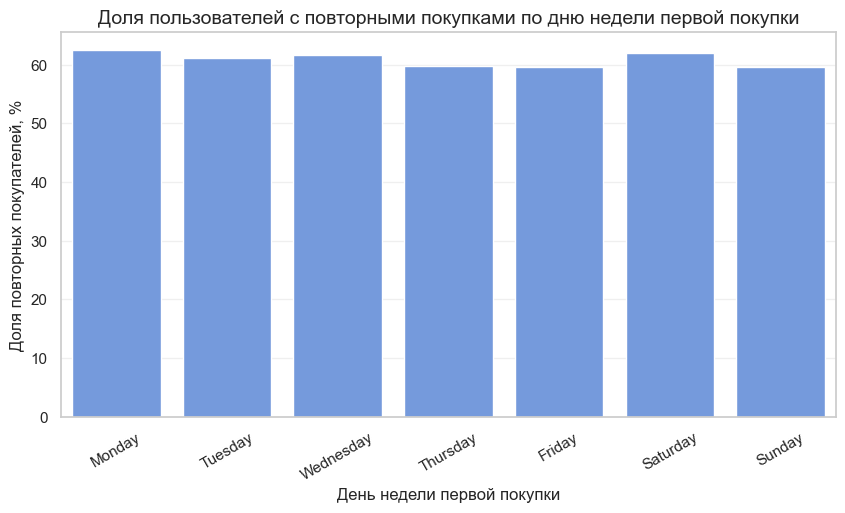

In [43]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 5))
sns.barplot(data=dow_stats, x='first_order_dow', y='repeat_share', color='cornflowerblue')
plt.title('Доля пользователей с повторными покупками по дню недели первой покупки', fontsize=14)
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля повторных покупателей, %')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.show()

Распределение доли повторных заказов по дням недели достаточно равномерное:
- Немного выше показатели у пользователей, впервые купивших в понедельник и субботу
- Минимальные значения — в четверг и пятницу
- Таким образом, чёткой зависимости между днём первой покупки и вероятностью возвращения не наблюдается, однако виден небольшой подъём лояльности у покупателей, совершающих первую покупку в начале недели или в выходные.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


,Группа,Средний интервал между заказами (дни)
0,2–4 заказа,21.468040
1,5+ заказов,10.203331


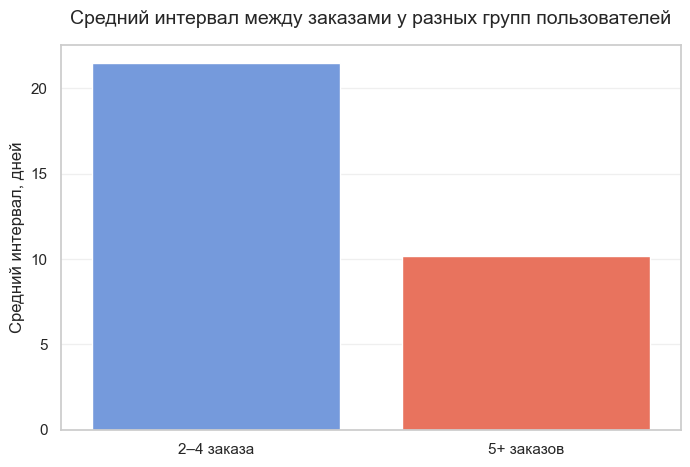

In [44]:
two_four = df_users[(df_users['orders_count'] >= 2) & (df_users['orders_count'] < 5)]
five_plus = df_users[df_users['orders_count'] >= 5]

#Средние значения
intervals_summary = pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'Средний интервал между заказами (дни)': [
        two_four['avg_days_between'].mean(),
        five_plus['avg_days_between'].mean()
    ]
})

display(intervals_summary)

plt.figure(figsize=(8, 5))
sns.barplot(
    x='Группа',
    y='Средний интервал между заказами (дни)',
    hue='Группа',
    data=intervals_summary,
    palette=['cornflowerblue', 'tomato'],
    legend=False
)

plt.title('Средний интервал между заказами у разных групп пользователей', fontsize=14, pad=15)
plt.ylabel('Средний интервал, дней')
plt.xlabel('')
plt.grid(axis='y', alpha=0.3)
plt.show()

- Пользователи, совершающие заказы реже 1 раза примерно в 3 недели, имеют низкую склонность к удержанию.
- Если пользователь начинает заказывать раз в 10 дней и чаще, он, с большей вероятностью, перейдёт в категорию лояльных клиентов.
- Рекомендация: стимулировать пользователей из первой группы к сокращению интервалов (напоминания, персональные предложения, скидки за быстрый повторный заказ).

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---


Корреляции с числом заказов:
orders_count        1.000000
orders_segment      0.637033
avg_days_between    0.369106
avg_tickets         0.254797
avg_revenue_rub     0.246428
first_region        0.075727
first_device        0.035708
first_event_type    0.034909
first_service       0.027343
Name: orders_count, dtype: float64


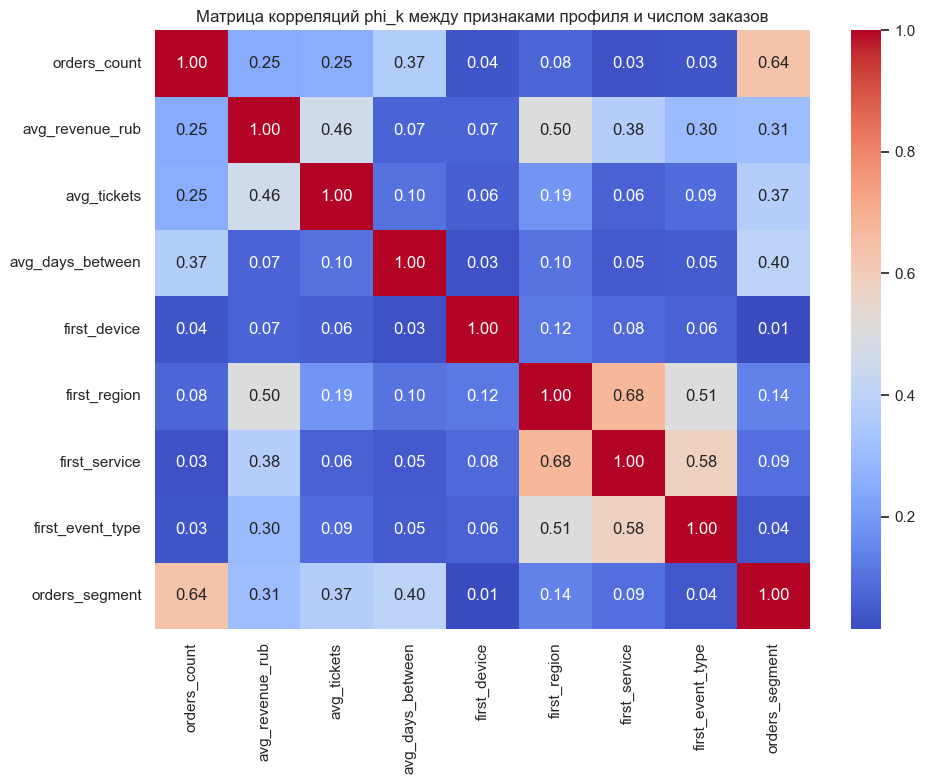

In [45]:
cols_for_corr = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets',
    'avg_days_between',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]


# --- 3. Создадим сегменты по числу заказов ---
def segment_orders(n):
    if n == 1:
        return '1 заказ'
    elif 2 <= n <= 4:
        return '2–4 заказа'
    else:
        return '5 и более'

df_users['orders_segment'] = df_users['orders_count'].apply(segment_orders)

# --- 4. Добавим новый признак в анализ ---
cols_for_corr_with_segment = cols_for_corr + ['orders_segment']

# --- 5. Рассчитаем корреляцию phi_k ---
phik_corr = df_users[cols_for_corr_with_segment].phik_matrix(
    interval_cols=['orders_count', 'avg_revenue_rub', 'avg_tickets', 'avg_days_between']
)

# --- 6. Посмотрим корреляции с количеством заказов ---
print("\nКорреляции с числом заказов:")
print(phik_corr['orders_count'].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Матрица корреляций phi_k между признаками профиля и числом заказов')
plt.tight_layout()
plt.show()

Наибольшая связь с числом заказов наблюдается у метрик, связанных с поведением пользователей:
- средний интервал между покупками (avg_days_between);
- средний чек (avg_revenue_rub);
- среднее число билетов в заказе (avg_tickets).

Слабо влияют демографические признаки и параметры первого заказа — устройство, оператор, тип события. Это значит, что лояльность пользователей формируется не столько в момент первой покупки, сколько через накопление опыта и взаимодействие с сервисом.
Региональная специфика играет небольшую роль — вероятно, из-за разницы в предложении мероприятий и плотности населения.
Высокая корреляция по сегменту лояльных покупателей ожидаема, так как сегменты формируются на основе количества заказов, поэтому зависимость прямая.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Для работа были создана витрина данных, включающая в себя 290611 строки и 15 столбцов. Датасет содержал в себе информацию о пользователях, их заказах, их стоимости, типом меорприятия, количества билетов в заказе, регионе и операторе.
Пропусков в данных не было, что упростило нашу дальнейшую работу. Пропуски в столбце о повторном заказе не являются важными для анализа, поэтому их мы не исключали. 

Была проведена фильтрация данных и из собранной витрине, был создан датасет с аггрегированными данными, которые помогли в дальнейшей аналитической работе по составлению портрета среднестатического пользователя сервиса Яндекс.Афиша. 
Такие как: количество заказов у одного пользователя, его средний чек (т.к. некоторые пользователи проводили покупки в тенге, их суммы были конвертированы по актуальному на 2024 год курсу), среднее количество билетов у пользователя, среднее количество дней между заказами, тип девайса с которого был совершен первый заказ, регион пользователя, билетный оператор, тип первого посещённого мероприятия, а также принадлежность пользователя к одной из двух групп: с двумя и более заказами и более, чем с пятью.



# Итоговый аналитический вывод по исследованию пользовательского поведения на Яндекс.Афише

## 1. Общие характеристики выборки
В анализ включено **20 978 пользователей**, совершивших **115 279 заказов**.  
Средняя выручка с одного заказа - **561 руб.**,  
среднее количество билетов - **2.75**,  
а средний интервал между заказами - **16.5 дней**.

- **61%** пользователей совершают повторные заказы (2+).
- **28%** относятся к категории **лояльных** (5+ заказов).
- Две крупнейшие области формируют почти **половину базы** пользователей.
- **Топ-5 операторов** обеспечивают **82%** пользователей.
- Более **80%** первых заказов совершаются **с мобильных устройств**, что подчёркивает важность мобильного UX.

---

## 2. Связь признаков первого заказа с удержанием
**Тип события** оказывает умеренное влияние:
- Пользователи, начавшие с **театра** или **выставки**, возвращаются чаще (около 64%).
- **Концерты** занимают среднюю позицию по удержанию (около 62%).
- **Спортивные мероприятия** и **сезонные ивенты** показывают более низкие показатели (≈57% и ниже).
- Гипотеза о большей лояльности спортивной аудитории **не подтвердилась**.

**Тип устройства** влияет слабо: десктоп-пользователи немного чаще возвращаются (63.5% против 61% у мобильных).

**Регион** и **оператор билетов** не оказывают существенного влияния: уровень удержания стабилен на уровне 60–63%.

---

## 3. Средняя выручка и количество билетов
**Связь среднего чека и лояльности:**
- Пользователи с **1 заказом** - средний чек **100–300 руб.**
- Пользователи с **2–4 заказами** - **300–700 руб.**
- Пользователи с **5+ заказами** - **400–600 руб.** и стабильное потребление.

**Вывод:** лояльные клиенты совершают заказы чаще и с более высоким средним чеком.

**Среднее количество билетов в заказе:**
- Наибольшее удержание у пользователей с **2–3 билетами** (около 73%).
- При среднем более **5 билетов** удержание снижается (<20%).

**Вывод:** умеренные групповые покупки чаще повторяются, чем массовые.

---

## 4. Временные характеристики
**День недели первой покупки** не оказывает заметного влияния:  
доли повторных заказов колеблются от **59.9% (пятница)** до **62.8% (понедельник, суббота)** — различия несущественные.

**Интервал между заказами** — ключевой фактор удержания:
- Пользователи, совершающие заказы **реже чем раз в 3 недели**, редко переходят в категорию лояльных.
- Если клиент делает новый заказ **в течение 10 дней**, вероятность перехода в группу 5+ заказов значительно выше.

**Вывод:** чем короче интервал между заказами, тем выше удержание.

---

## 5. Корреляционный анализ факторов лояльности

| Признак | Связь с количеством заказов |
|----------|-----------------------------|
| Средний интервал между заказами | Сильная отрицательная |
| Средний чек (revenue_rub) | Умеренно положительная |
| Среднее количество билетов | Положительная |
| Тип устройства / региона / оператора | Слабая |
| Тип первого события | Слабая–умеренная |

**Интерпретация:** удержание определяется поведенческими характеристиками, а не демографическими или техническими.  
Лояльность формируется не при первой покупке, а в процессе накопления опыта пользователя.

---

## 6. Общий итог
1. **62%** пользователей совершают повторные заказы, **28%** становятся лояльными.  
2. **Ключевые признаки удержания:** высокий средний чек, 2–3 билета в заказе, короткий интервал между покупками.  
3. **Наибольшая вероятность удержания** — у пользователей, впервые купивших билеты в театр или на концерт.  
4. **Регион, устройство и оператор** почти не влияют на возврат.  
5. **Поведенческие метрики важнее демографических.**

---

## 7. Рекомендации
- Стимулировать **ранний повторный заказ** (скидки при покупке в течение 7–10 дней).  
- Развивать **театральное и концертное направление** как точки входа.  
- Оптимизировать **мобильный интерфейс**, где совершается большинство первых заказов.  
- Сфокусировать удержание на **аудитории с 2–3 билетами и чеком 400–700 руб.**

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**